# Open Access Evidence in Unpaywall - Python Version

This notebook is based on the blog article 'Open Access Evidence in Unpaywall' by Najko Jahn and Anne Hobert. The original post can be found here: https://subugoe.github.io/scholcomm_analytics/posts/unpaywall_evidence/.  

Although this work serves as a complete translation of the source code from R into Python, the main purpose was to update the results from the blog article. For that, the updated Unpaywall data dump from November 2019 was used.

In [1]:
#!pip install google-cloud-bigquery[pandas]
#!pip install seaborn

In [2]:
from google.cloud import bigquery
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
import seaborn as sns

In [3]:
# increase plot resolution
plt.rcParams['figure.dpi'] = 600

In [4]:
%%capture
client = bigquery.Client(project='api-project-764811344545')

In [5]:
# database snapshots
upw_08_12 = '`oadoi_full.mongo_export_upwNov19_08_12`'
upw_13_18 = '`oadoi_full.mongo_export_upwNov19_13_19`'

In [6]:
client.query(f"""
            SELECT * 
            FROM {upw_13_18} 
            WHERE year=2018
            AND genre="journal-article" 
            LIMIT 10
            """).to_dataframe()

,oa_status,year,genre,updated,published_date,journal_is_in_doaj,journal_is_oa,journal_issns,oa_locations,doi,is_oa,publisher,journal_name,data_standard
0,gold,2018,journal-article,2019-11-01 22:51:32.142428+00:00,2018-03-29,True,True,1560-7917,[{'url': 'https://doi.org/10.2807/1560-7917.es...,10.2807/1560-7917.es.2018.23.13.180329-3,True,European Centre for Disease Control and Preven...,Eurosurveillance,2
1,bronze,2018,journal-article,2019-10-31 06:40:37.599979+00:00,2018-01-01,False,False,"0035-2764,1950-6694",[{'url': 'https://www.cairn.info/load_pdf.php?...,10.3917/reco.695.0683,True,CAIRN,Revue économique,2
2,gold,2018,journal-article,2019-10-31 16:20:21.743703+00:00,2018-03-12,True,True,1664-3224,[{'url': 'https://www.frontiersin.org/articles...,10.3389/fimmu.2018.00438,True,Frontiers Media SA,Frontiers in Immunology,2
3,gold,2018,journal-article,2019-11-07 06:20:25.027034+00:00,2018-08-07,True,True,2045-2322,[{'url': 'https://www.nature.com/articles/s415...,10.1038/s41598-018-29997-0,True,"Springer Nature America, Inc",Scientific Reports,2
4,gold,2018,journal-article,2019-11-01 04:59:15.673051+00:00,2018-01-26,True,True,1664-302X,[{'url': 'https://www.frontiersin.org/articles...,10.3389/fmicb.2018.00019,True,Frontiers Media SA,Frontiers in Microbiology,2
5,green,2018,journal-article,2019-11-14 20:18:43.150844+00:00,2018-12-07,False,False,"0305-8719,2041-4927",[{'url': 'https://hal.archives-ouvertes.fr/hal...,10.1144/sp467.15,True,Geological Society of London,"Geological Society, London, Special Publications",2
6,green,2018,journal-article,2019-11-16 23:50:30.876520+00:00,2018-11-29,False,False,"2470-0010,2470-0029",[{'url': 'https://helda.helsinki.fi/bitstream/...,10.1103/physrevd.98.103533,True,American Physical Society (APS),Physical Review D,2
7,gold,2018,journal-article,2019-11-16 20:20:50.499946+00:00,2018-01-23,False,True,2291-0026,[{'url': 'http://www.cmajopen.ca/content/6/1/E...,10.9778/cmajo.20170159,True,Joule Inc.,CMAJ Open,2
8,green,2018,journal-article,2019-10-31 01:01:45.923146+00:00,2018-10-06,False,False,"1387-2877,1875-8908",[{'url': 'http://spiral.imperial.ac.uk/bitstre...,10.3233/jad-180101,True,IOS Press,Journal of Alzheimer's Disease,2
9,gold,2018,journal-article,2019-10-31 10:50:00.933552+00:00,2018-04-10,True,True,1664-462X,[{'url': 'https://www.frontiersin.org/articles...,10.3389/fpls.2018.00470,True,Frontiers Media SA,Frontiers in Plant Science,2


## Open Access availability (is_oa)

In [7]:
oa_08_12 = client.query(f"""
                        SELECT year, is_oa, COUNT(DISTINCT(doi)) AS n 
                        FROM {upw_08_12} 
                        WHERE genre="journal-article" 
                        GROUP BY year, is_oa
                        """).to_dataframe()

oa_13_18 = client.query(f"""
                        SELECT year, is_oa, COUNT(DISTINCT(doi)) AS n 
                        FROM {upw_13_18} 
                        WHERE year<2019 AND genre="journal-article" 
                        GROUP BY year, is_oa
                        """).to_dataframe()

In [8]:
df = pd.concat([oa_08_12, oa_13_18])
df.year = pd.to_datetime(df.year.apply(lambda x: str(x) + "-01-01"))
df['prop'] = df.groupby(['year'])['n'].transform(lambda x: x / x.sum())
df = df.sort_values(by=['year']).reset_index(drop=True)
df

,year,is_oa,n,prop
0,2008-01-01,True,646079,0.312379
1,2008-01-01,False,1422175,0.687621
2,2009-01-01,False,1528180,0.676550
3,2009-01-01,True,730604,0.323450
4,2010-01-01,True,823574,0.328862
5,2010-01-01,False,1680740,0.671138
6,2011-01-01,False,1527730,0.622085
7,2011-01-01,True,928090,0.377915
8,2012-01-01,True,1056857,0.401042
9,2012-01-01,False,1578421,0.598958


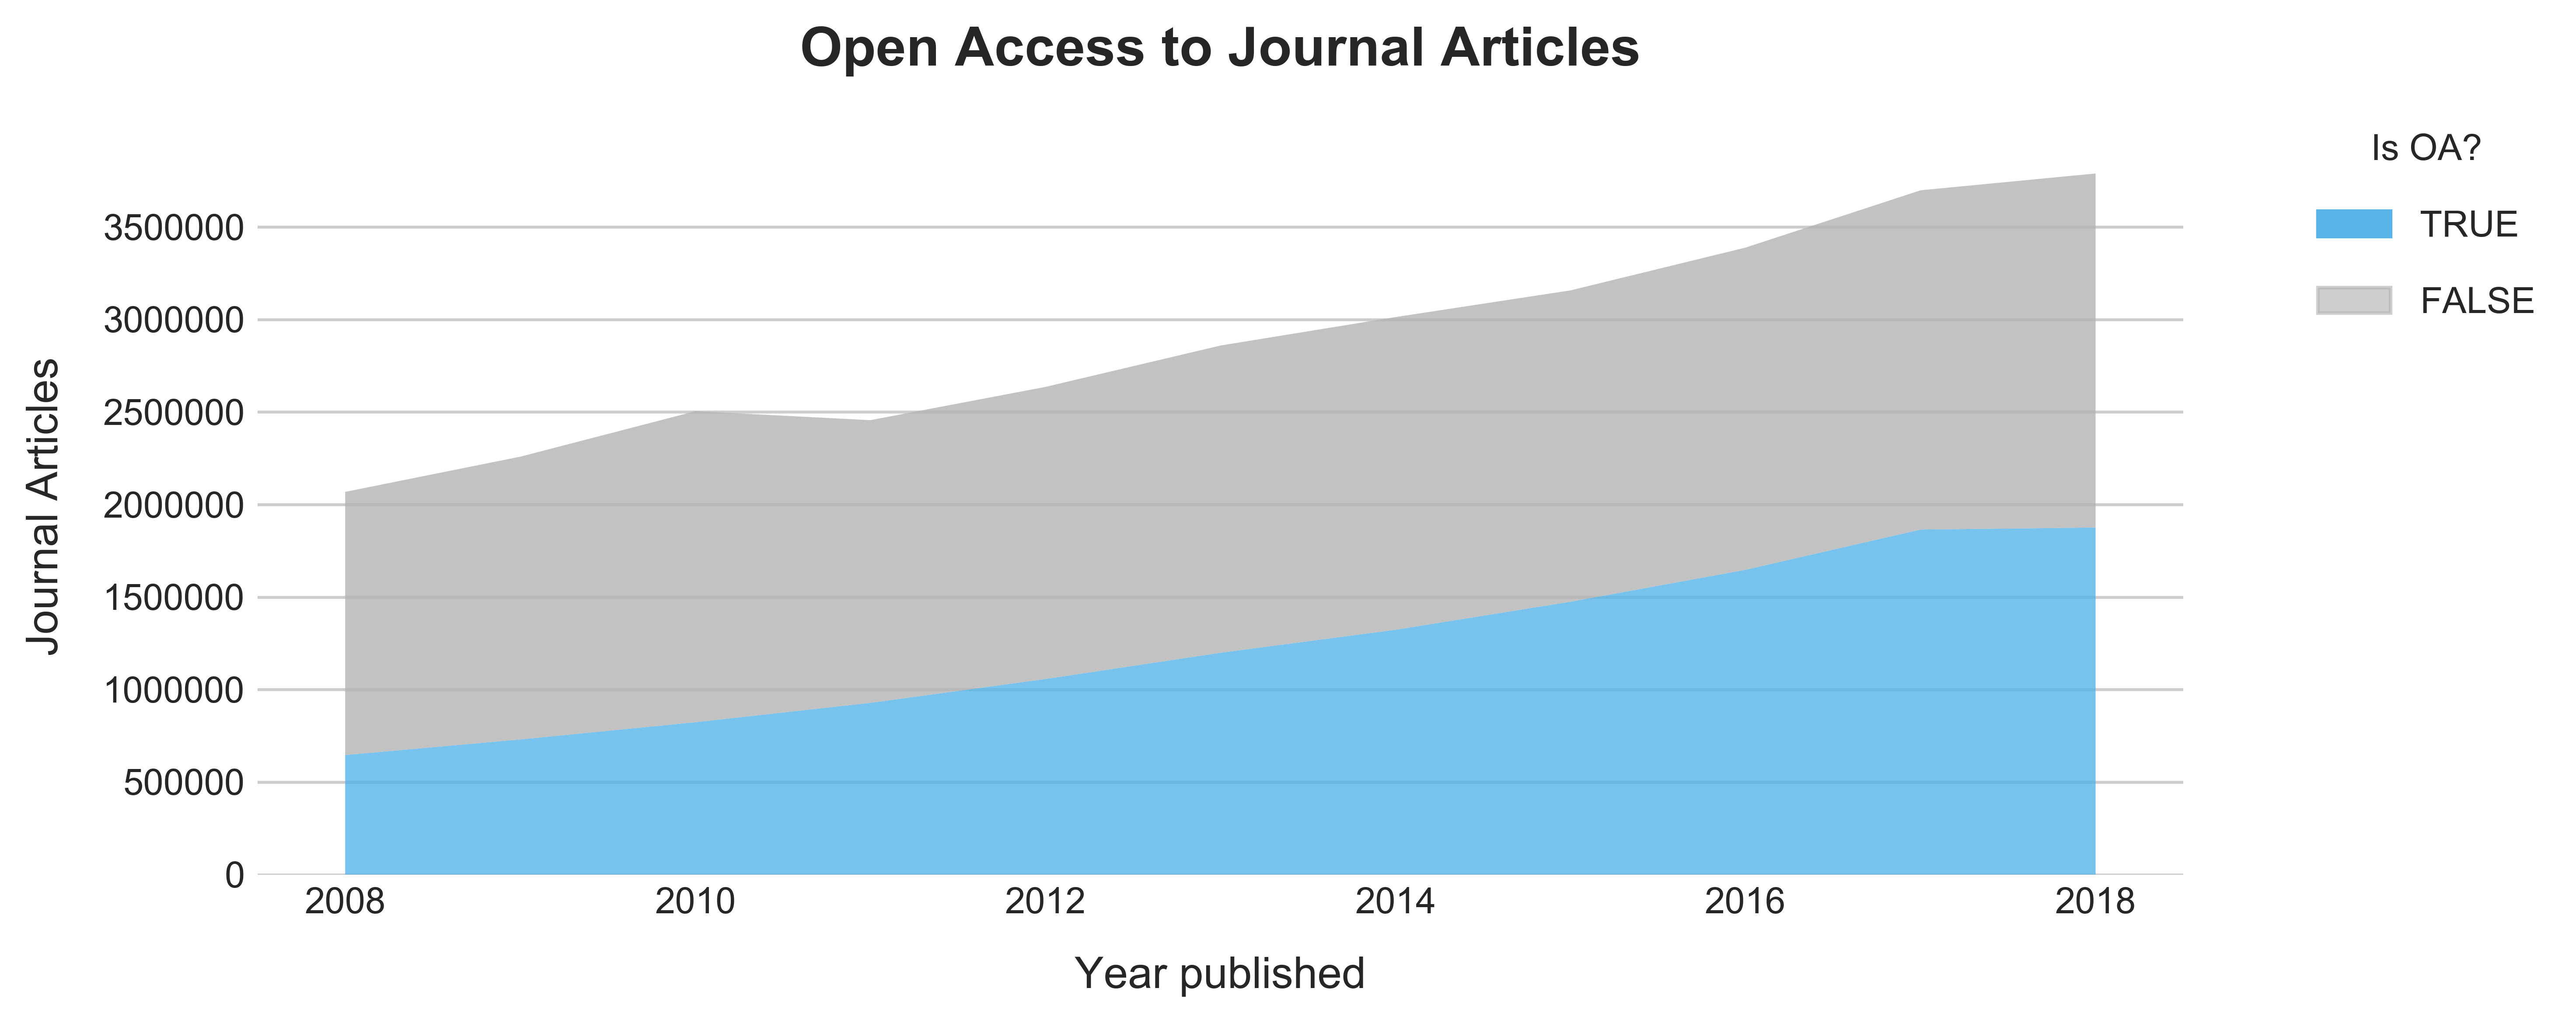

In [9]:
x = df.year.unique()
y1 = df[df.is_oa == True].n
y2 = df[df.is_oa == False].n

plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = [10, 4]
plt.grid(False, which='both', axis='x')
plt.box(False)
plt.stackplot(x, y1, y2, colors=['#56B4E9', '#b3b3b3a0'], alpha=0.8)
plt.title('Open Access to Journal Articles', fontdict={'fontsize': 15, 'fontweight': 600}, \
          pad=20)
plt.xlabel('Year published', labelpad=10, fontdict={'fontsize': 12, 'fontweight': 500})
plt.ylabel('Journal Articles', labelpad=10, fontdict={'fontsize': 12, 'fontweight': 500})
is_oa_patch = mpatches.Patch(color='#56B4E9', label='TRUE')
is_not_oa_patch = mpatches.Patch(color='#b3b3b3a0', label='FALSE')
plt.legend(handles=[is_oa_patch, is_not_oa_patch], title='Is OA?', \
           fontsize='medium', bbox_to_anchor=(1.2, 1.05), labelspacing=1.2)

plt.tight_layout()

plt.show()

As expected, the total number of journal articles has increased, compared to the previous results from the blog article. In fact, the number of articles with a distinct DOI included in the Unpaywall data dump from November 2019 has increased by 2% in comparison to the February 2019 data dump used in the original blog post. In addition, the share of open access articles has increased by 6%. Overall, 13,569,137 freely available articles were published between 2008 and 2018. 

## Unpaywall Open Access Hosting Types (host_type)

In [10]:
HOST_TYPE_08_12_QUERY = f"""
                        SELECT year, host_type, journal_is_in_doaj, 
                            COUNT(DISTINCT(doi)) AS number_of_articles 
                        FROM {upw_08_12}, UNNEST (oa_locations) 
                        WHERE genre="journal-article" AND is_best=true 
                        GROUP BY year, host_type, journal_is_in_doaj
                        """

HOST_TYPE_13_18_QUERY = f"""
                        SELECT year, host_type, journal_is_in_doaj, 
                            COUNT(DISTINCT(doi)) AS number_of_articles 
                        FROM {upw_13_18}, UNNEST (oa_locations) 
                        WHERE genre="journal-article" AND year<2019 AND is_best=true 
                        GROUP BY year, host_type, journal_is_in_doaj
                        """

In [11]:
host_type_08_12_query_df = client.query(HOST_TYPE_08_12_QUERY).to_dataframe()
host_type_13_18_query_df = client.query(HOST_TYPE_13_18_QUERY).to_dataframe()

host_type_df = pd.concat([host_type_08_12_query_df, host_type_13_18_query_df])
host_type_df.year = pd.to_datetime(host_type_df.year.apply(lambda x: str(x) + "-01-01"))
host_type_df = host_type_df.sort_values(by=['year']).reset_index(drop=True)

host_type_df.loc[host_type_df['host_type'] == 'publisher', 'host'] = 'Other Journals'
host_type_df.loc[host_type_df['host_type'] == 'repository', 'host'] = 'Repositories only'
host_type_df.loc[host_type_df['journal_is_in_doaj'] == True, 'host'] = 'DOAJ-listed Journal'

host_type_df

,year,host_type,journal_is_in_doaj,number_of_articles,host
0,2008-01-01,publisher,True,92337,DOAJ-listed Journal
1,2008-01-01,repository,False,258587,Repositories only
2,2008-01-01,publisher,False,295155,Other Journals
3,2009-01-01,publisher,True,114857,DOAJ-listed Journal
4,2009-01-01,repository,False,283108,Repositories only
5,2009-01-01,publisher,False,332639,Other Journals
6,2010-01-01,repository,False,299670,Repositories only
7,2010-01-01,publisher,False,368068,Other Journals
8,2010-01-01,publisher,True,155836,DOAJ-listed Journal
9,2011-01-01,repository,True,1,DOAJ-listed Journal


In [12]:
all_articles = host_type_df.groupby(['year'])['number_of_articles'].sum() \
                            .reset_index(name='number_of_articles')

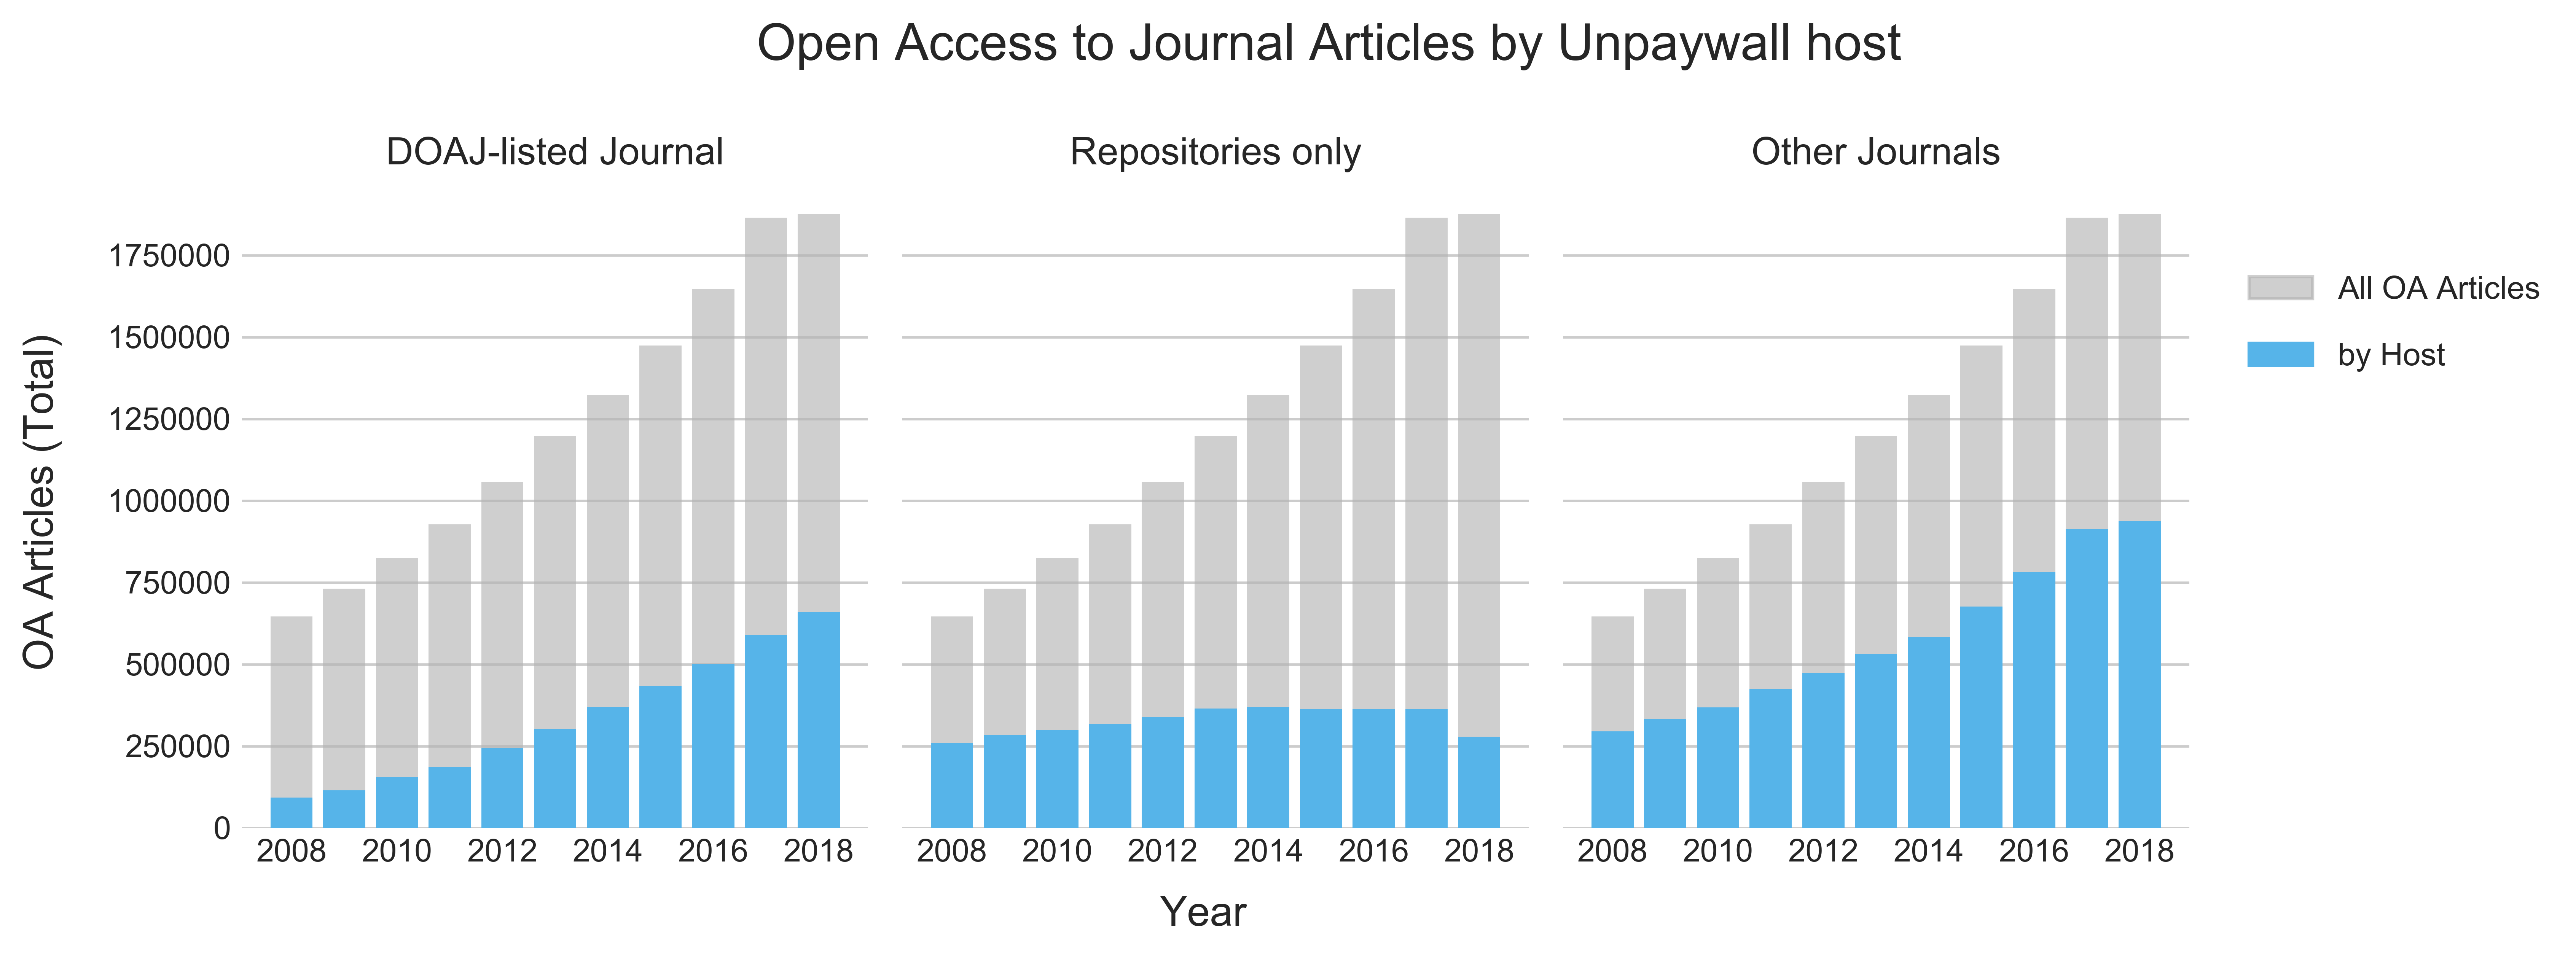

In [13]:
x = all_articles['year'].dt.year
y_total = all_articles.number_of_articles

plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = [11, 3.5]

fig,(axes) = plt.subplots(nrows=1, ncols=3)

fig.suptitle('Open Access to Journal Articles by Unpaywall host', fontsize=16, y=1.10)

for i, host in enumerate(host_type_df.host.unique(), 1):
    
    ax = plt.subplot(1,3,i)
    y_stacked = host_type_df[host_type_df.host==host] \
                    .groupby(['year'])['number_of_articles'].sum() \
                    .reset_index(name='number_of_articles').number_of_articles
    ax.bar(x, y_total, color='#b3b3b3a0')
    ax.bar(x, y_stacked, color='#56B4E9')
    ax.set_title(host, fontdict={'fontsize': 12, 'fontweight': 500})

    ax.set_frame_on(False)
    ax.grid(False, which='both', axis='x')

    if i > 1:
        ax.set_yticklabels([], visible=False)
        
# common xlabel   
fig.text(0.45, -0.03, 'Year', ha='center', 
         fontdict={'fontsize': 13, 'fontweight': 500})

# common ylabel
fig.text(-0.02, 0.5, 'OA Articles (Total)', va='center', rotation='vertical', 
         fontdict={'fontsize': 13, 'fontweight': 500})

by_host_patch = mpatches.Patch(color='#56B4E9', label='by Host')
all_oa_patch = mpatches.Patch(color='#b3b3b3a0', label='All OA Articles')
plt.legend(handles=[all_oa_patch, by_host_patch], fontsize='medium', \
           bbox_to_anchor=(1.05, 0.9), labelspacing=1.2)

fig.tight_layout()

plt.show()

As can be seen from the figure, the proportion of open access articles that are accessible through journals which are not listed in DOAJ had rapidly increased in the year 2018 in comparison to the previous results. Consequently, the share of open access articles provided by DOAJ-listed journals has decreased from 44% to 42%. 

## Unpaywall Open Access Evidence Types (evidence)

In [14]:
EVIDENCE_08_12_QUERY = f"""
                        SELECT evidence, year, is_best, 
                            COUNT(distinct(doi)) AS number_of_articles 
                        FROM {upw_08_12}, UNNEST (oa_locations) 
                        WHERE genre="journal-article" 
                        GROUP BY evidence, year, is_best
                        """

EVIDENCE_13_18_QUERY = f"""
                        SELECT evidence, year, is_best, 
                            COUNT(distinct(doi)) AS number_of_articles 
                        FROM {upw_13_18}, UNNEST (oa_locations) 
                        WHERE genre="journal-article" AND year < 2019 
                        GROUP BY evidence, year, is_best
                        """

In [15]:
evidence_08_12 = client.query(EVIDENCE_08_12_QUERY).to_dataframe()
evidence_13_18 = client.query(EVIDENCE_13_18_QUERY).to_dataframe()

In [16]:
evidence_df = pd.concat([evidence_08_12, evidence_13_18])
evidence_df.year = pd.to_datetime(evidence_df.year.apply(lambda x: str(x) + "-01-01"))

evidence_df.head()

,evidence,year,is_best,number_of_articles
0,oa repository (via OAI-PMH title and first aut...,2012-01-01,False,86472
1,oa repository (via OAI-PMH doi match),2012-01-01,False,246190
2,oa journal (via doaj),2012-01-01,True,57654
3,oa repository (semantic scholar lookup),2012-01-01,False,356094
4,oa journal (via doaj),2012-01-01,False,182334


In [17]:
articles_per_type_df = evidence_df.groupby(['evidence']).number_of_articles \
                        .sum() \
                        .to_frame() \
                        .reset_index() \
                        .sort_values(by=['number_of_articles'], ascending=False) \
                        .reset_index(drop=True)
    
articles_per_type_df['prop'] = articles_per_type_df['number_of_articles'] \
                                .transform(lambda x: 
                                           x / articles_per_type_df['number_of_articles'] \
                                           .sum() * 100)

articles_per_type_df['cumul'] = articles_per_type_df.prop.cumsum()

articles_per_type_table = articles_per_type_df.copy()
articles_per_type_table.prop = articles_per_type_table.prop \
                                    .apply(lambda x: '{0:.2f}'.format(x))

articles_per_type_table.cumul = articles_per_type_table.cumul \
                                    .apply(lambda x: '{0:.2f}'.format(x))

articles_per_type_table.columns = ['Evidence Types', 
                                   'Number of Articles', 
                                   'Proportion of all Articles in %', 
                                   'Cumulative Proportion in %']

articles_per_type_table

,Evidence Types,Number of Articles,Proportion of all Articles in %,Cumulative Proportion in %
0,oa repository (semantic scholar lookup),5759641,20.12,20.12
1,oa repository (via OAI-PMH doi match),4467382,15.60,35.72
2,open (via free pdf),4427452,15.47,51.19
3,open (via page says license),3653314,12.76,63.95
4,oa journal (via doaj),3577409,12.50,76.45
5,oa repository (via pmcid lookup),3237547,11.31,87.75
6,oa repository (via OAI-PMH title and first aut...,1699654,5.94,93.69
7,oa journal (via observed oa rate),781574,2.73,96.42
8,open (via crossref license),594003,2.07,98.50
9,open (via page says Open Access),101344,0.35,98.85


In [18]:
sum_other = articles_per_type_df \
                .loc[articles_per_type_df['prop'] < 1] \
                .number_of_articles \
                .sum()

articles_per_type_other_df = pd.DataFrame([['other', sum_other]], 
                                          columns=['evidence', 'number_of_articles'])

articles_per_type_keep_df = articles_per_type_df.loc[articles_per_type_df['prop'] > 1]

articles_per_type_grouped_df = pd.concat([articles_per_type_other_df, 
                                          articles_per_type_keep_df])

articles_per_type_grouped_df = articles_per_type_grouped_df \
                                .groupby(['evidence']) \
                                .number_of_articles.sum() \
                                .to_frame().reset_index() \
                                .sort_values(by=['number_of_articles'], ascending=False) \
                                .reset_index(drop=True)

articles_per_type_grouped_df['prop'] = articles_per_type_grouped_df['number_of_articles'] \
                        .transform(lambda x: 
                        x / articles_per_type_grouped_df['number_of_articles'].sum() * 100)

articles_per_type_grouped_df['cumul'] = articles_per_type_grouped_df.prop.cumsum()

In [19]:
evidence_grouped_df = evidence_df.copy()

list_of_small_evidence_types = articles_per_type_df \
                                .loc[articles_per_type_df['prop'] < 1] \
                                .evidence.tolist()

evidence_grouped_df.evidence = evidence_grouped_df \
                                .evidence.replace(list_of_small_evidence_types, 'other')

evidence_grouped_df = evidence_grouped_df.groupby(['evidence', 'is_best', 'year']) \
                                .number_of_articles.sum() \
                                .to_frame().reset_index() \
                                .sort_values(by=['number_of_articles'], ascending=False) \
                                .reset_index(drop=True)

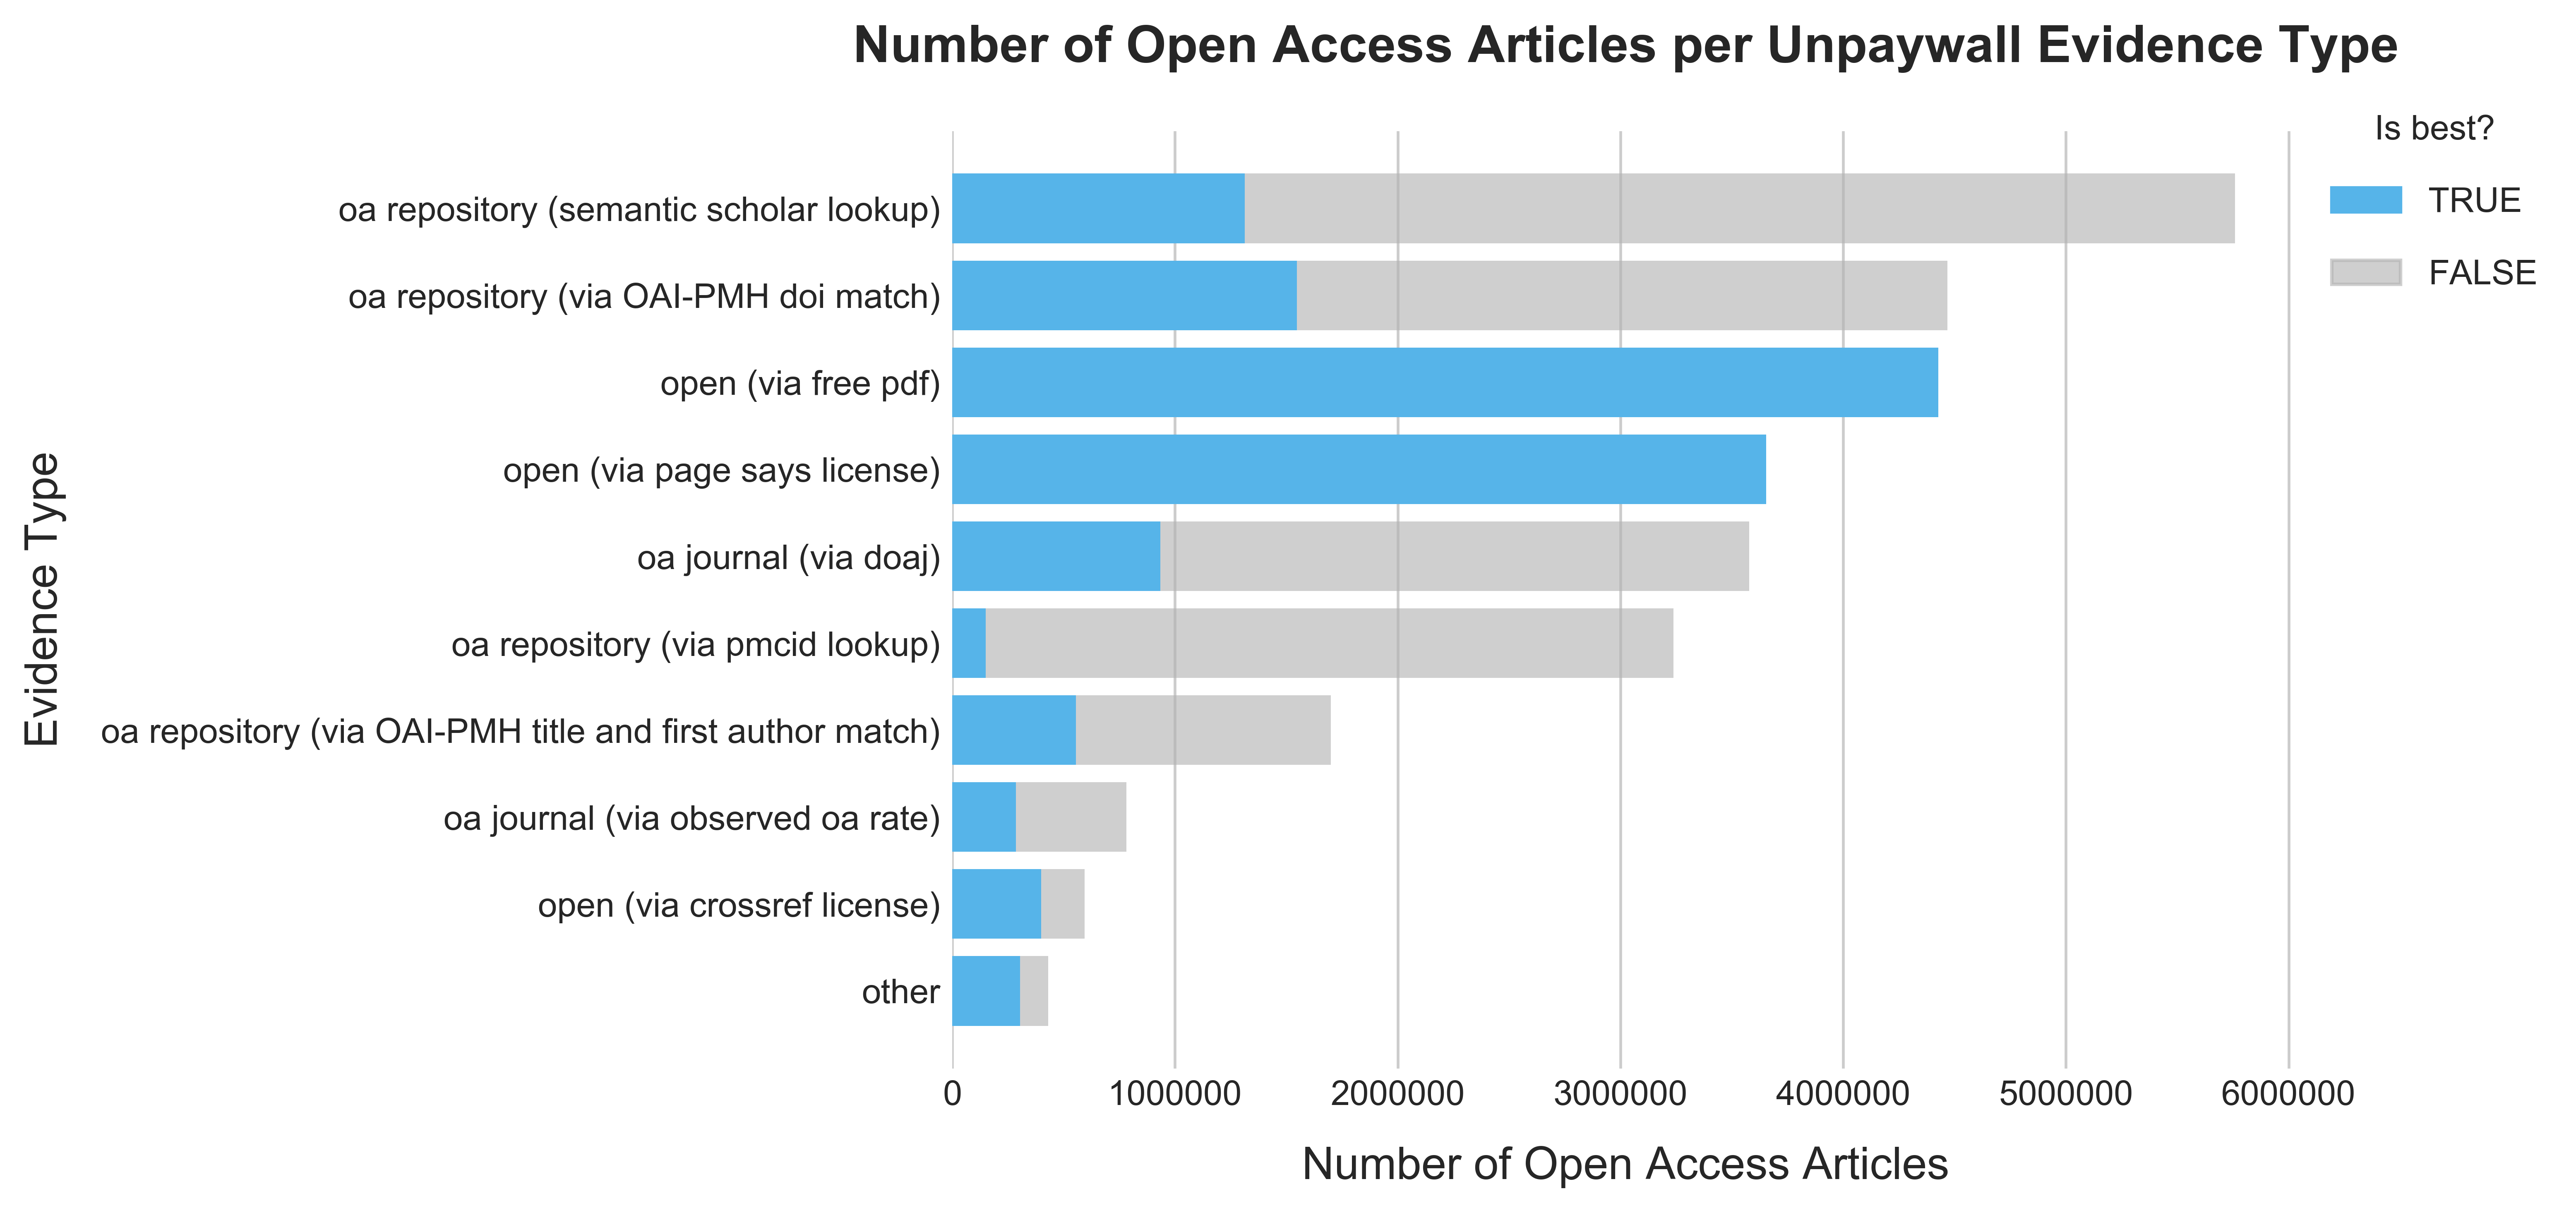

In [20]:
evidence_grouped_plot_df = evidence_grouped_df \
                            .groupby(['evidence', 'is_best']) \
                            .number_of_articles.sum() \
                            .to_frame().reset_index() \
                            .sort_values(by=['number_of_articles'], ascending=True) \
                            .reset_index(drop=True)

articles_per_type_grouped_plot_df = articles_per_type_grouped_df \
                                    .sort_values(by=['number_of_articles'], ascending=True) \
                                    .reset_index(drop=True)

y1 = articles_per_type_grouped_plot_df.evidence
x_total = articles_per_type_grouped_plot_df.number_of_articles
x_stacked = evidence_grouped_plot_df[evidence_grouped_plot_df.is_best == True] \
                        .set_index('evidence') \
                        .reindex(index=articles_per_type_grouped_plot_df['evidence']) \
                        .reset_index().number_of_articles

plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = [7, 5]
plt.grid(False, which='both', axis='y')
plt.box(False)

ax1 = plt.barh(y1, x_total, color='#b3b3b3a0')
ax2 = plt.barh(y1, x_stacked, color='#56B4E9')

plt.title('Number of Open Access Articles per Unpaywall Evidence Type', 
          fontdict={'fontsize': 15, 'fontweight': 600}, pad=20)
plt.xlabel('Number of Open Access Articles', labelpad=10, 
           fontdict={'fontsize': 13, 'fontweight': 500})

plt.ylabel('Evidence Type', labelpad=10, fontdict={'fontsize': 13, 'fontweight': 500})

is_best_patch = mpatches.Patch(color='#56B4E9', label='TRUE')
is_not_best_patch = mpatches.Patch(color='#b3b3b3a0', label='FALSE')
plt.legend(handles=[is_best_patch, is_not_best_patch], title='Is best?', 
           fontsize='medium', bbox_to_anchor=(1.2, 1.05), labelspacing=1.2)

plt.show()

The figure provides two types of evidence that were not specifically mentioned in the previous work: 'oa repository (semantic scholar lookup)' and 'oa journal (via observed rate)'. Apparently these evidence types are responsible for the overall increase in articles between the two data dumps from February and November 2019.

In [21]:
y1 = evidence_grouped_df.sort_values(by=['year'], ascending=True) \
                        .reset_index(drop=False) \
                        ['year'].dt.year.unique()

plt.style.use('seaborn-whitegrid')

fig, (axes) = plt.subplots(nrows=5, 
                           ncols=2, 
                           sharex=True, 
                           sharey=True, 
                           figsize=(12,12))

# get a one-dimensional array
axes = axes.reshape(-1)

fig.suptitle('Unpaywall Open Access Evidence Categories per Year', fontsize=16, y=1.05)

for i, ax in enumerate(axes, 1):
    
    ax = plt.subplot(5,2,i, sharey=axes[0], sharex=axes[0])    
    
    if i % 2 == 0:
        plt.setp(ax.get_yticklabels(), visible=False)
    
    evidence = evidence_grouped_df.evidence.unique()[i-1]

    x_total = evidence_grouped_df[evidence_grouped_df.evidence == evidence] \
                            .groupby(['year']) \
                            .number_of_articles.sum() \
                            .to_frame().reset_index() \
                            .number_of_articles

    x_stacked = evidence_grouped_df[evidence_grouped_df.evidence == evidence] \
                            .loc[evidence_grouped_df.is_best == True] \
                            .groupby(['year']) \
                            .number_of_articles.sum() \
                            .to_frame().reset_index() \
                            .number_of_articles

    ax = plt.bar(y1, x_total, color='#b3b3b3a0')
    ax = plt.bar(y1, x_stacked, color='#56B4E9')
    plt.title(evidence, fontdict={'fontsize': 12, 'fontweight': 500}, pad=0.2)
    
    plt.grid(False, which='both', axis='x')
    plt.box(False)

# common xlabel   
fig.text(0.52, -0.03, 'Publication Year', ha='center', 
         fontdict={'fontsize': 13, 'fontweight': 500})

# common ylabel
fig.text(-0.04, 0.5, 'Number of Open Access Articles', va='center', rotation='vertical', 
         fontdict={'fontsize': 13, 'fontweight': 500})

is_best_patch = mpatches.Patch(color='#56B4E9', label='TRUE')
is_not_best_patch = mpatches.Patch(color='#b3b3b3a0', label='FALSE')
fig.legend(handles=[is_best_patch, is_not_best_patch], title='Is best?', 
           fontsize='large', title_fontsize='x-large', 
           bbox_to_anchor=(1.15, 0.95), labelspacing=1.2)

plt.tight_layout()

plt.show()

## Overlap of Open Access Provision and Evidence Types

In [22]:
HOST_TYPE_INTERSECT_08_12_QUERY = f"""
                                    SELECT year, host_type_count, 
                                        count(distinct(doi)) as number_of_articles 
                                    FROM 
                                        (SELECT doi, year,
                                            STRING_AGG(DISTINCT(host_type) 
                                        ORDER BY host_type) 
                                        as host_type_count 
                                        FROM {upw_08_12}, UNNEST (oa_locations)
                                        WHERE genre="journal-article" 
                                        GROUP BY doi, year) 
                                    GROUP BY host_type_count, year 
                                    ORDER BY number_of_articles desc
                                    """

HOST_TYPE_INTERSECT_13_18_QUERY = f"""
                                    SELECT year, host_type_count, 
                                        count(distinct(doi)) as number_of_articles 
                                    FROM 
                                        (SELECT doi, year, 
                                        STRING_AGG(DISTINCT(host_type) 
                                        ORDER BY host_type) as host_type_count
                                        FROM {upw_13_18}, UNNEST (oa_locations) 
                                        WHERE genre="journal-article" AND year < 2019 
                                        GROUP BY doi, year) 
                                    GROUP BY host_type_count, year 
                                    ORDER BY number_of_articles desc
                                    """

In [23]:
host_type_08_12_intersect_df = client.query(HOST_TYPE_INTERSECT_08_12_QUERY).to_dataframe()
host_type_13_18_intersect_df = client.query(HOST_TYPE_INTERSECT_13_18_QUERY).to_dataframe()
host_type_intersect_df = pd.concat([host_type_08_12_intersect_df, 
                                    host_type_13_18_intersect_df])

host_type_intersect_df.year = pd.to_datetime(host_type_intersect_df.year \
                                             .apply(lambda x: str(x) + "-01-01"))

host_type_intersect_df \
    .loc[host_type_intersect_df['host_type_count'] == 'publisher', 'host'] = 'Publisher only'
host_type_intersect_df \
    .loc[host_type_intersect_df['host_type_count'] == 'publisher,repository', 
         'host'] = 'Publisher & Repository'
host_type_intersect_df \
    .loc[host_type_intersect_df['host_type_count'] == 'repository', 
         'host'] = 'Repositories only'

In [24]:
articles_total_by_year_df = df.groupby(['year']).n.sum().to_frame().reset_index()
articles_total_by_year_df.columns = ['year', 'all_articles']

host_type_intersect_df = pd.merge(articles_total_by_year_df, 
                                  host_type_intersect_df, on='year', how='right')

host_type_intersect_df = host_type_intersect_df.groupby(['year', 'host']) \
                                    .sum().eval('prop = number_of_articles/all_articles') \
                                    .reset_index()

host_type_intersect_df.head()

,year,host,all_articles,number_of_articles,prop
0,2008-01-01,Publisher & Repository,2068254,184598,0.089253
1,2008-01-01,Publisher only,2068254,202894,0.098099
2,2008-01-01,Repositories only,2068254,258587,0.125027
3,2009-01-01,Publisher & Repository,2258784,216379,0.095794
4,2009-01-01,Publisher only,2258784,231117,0.102319


In [25]:
host_type_all = host_type_intersect_df.copy()
host_type_all['prop'] = host_type_intersect_df.groupby(['year'])['prop'] \
                    .transform(lambda x: x.sum())

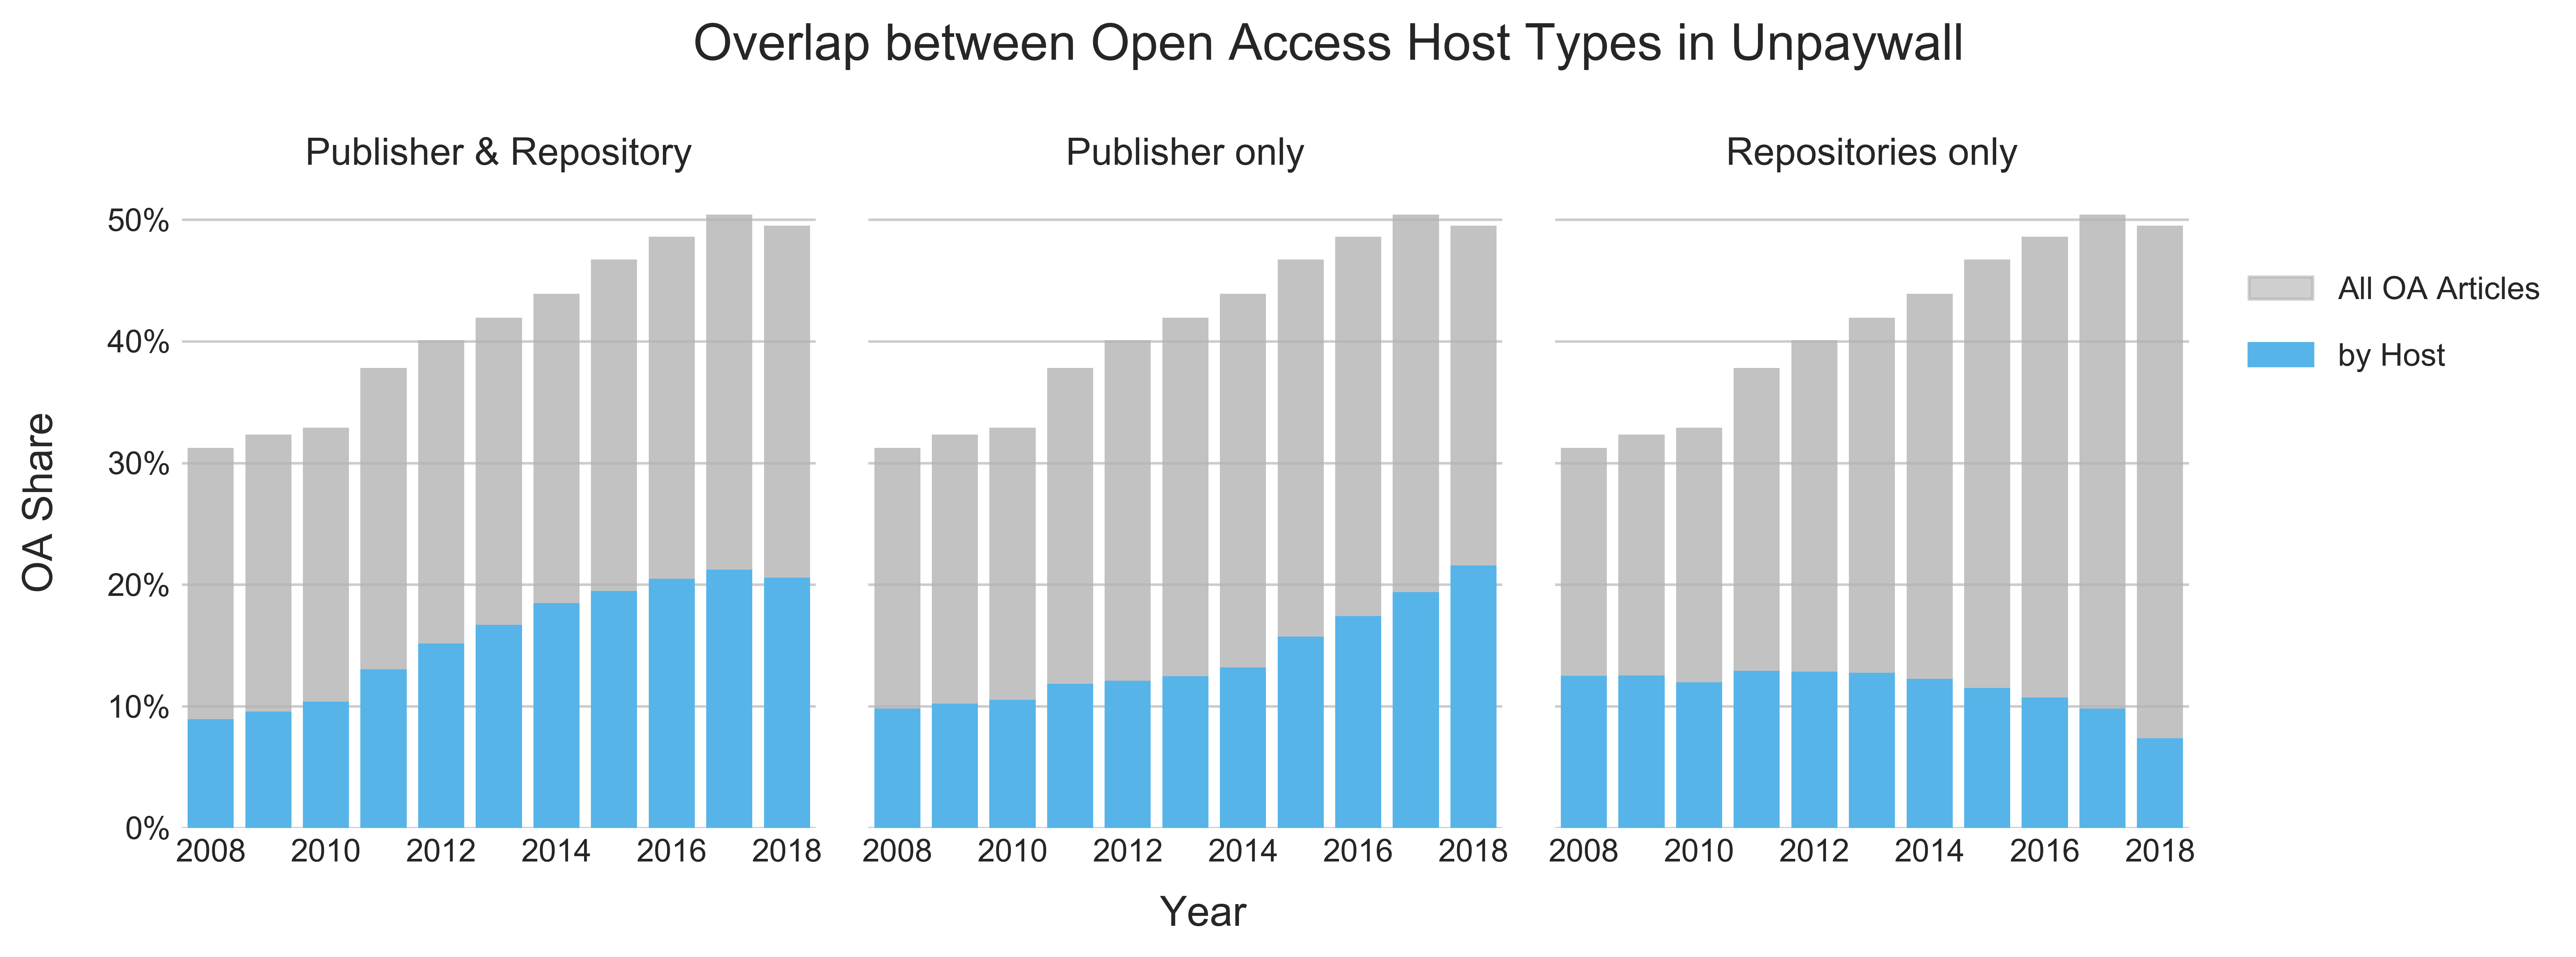

In [26]:
x = host_type_intersect_df['year'].dt.year
y = host_type_all.prop

plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = [11, 3.5] 

fig,(axes) = plt.subplots(nrows=1, ncols=3)

fig.suptitle('Overlap between Open Access Host Types in Unpaywall', fontsize=16, y=1.10)
    
for i, host in enumerate(host_type_intersect_df.host.unique(), 1):
    ax = plt.subplot(1,3,i)
    y_stacked = host_type_intersect_df[host_type_intersect_df.host == host].prop
    sns.barplot(x, y, color='#b3b3b3a0', alpha=0.8, saturation=1, ci=None)
    sns.barplot(x, y_stacked, color='#56B4E9', alpha=1, saturation=1, ci=None)
    ax.set_title(host, fontdict={'fontsize': 12, 'fontweight': 500})
    
    ax.set_frame_on(False)
    ax.grid(False, which='both', axis='x')
    ax.set(xlabel='', ylabel='')
    for label in ax.get_xticklabels()[1::2]:
        label.set_visible(False)
        
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    
    if i > 1:
        ax.set_yticklabels([], visible=False)
        
# common xlabel   
fig.text(0.45, -0.03, 'Year', ha='center', 
         fontdict={'fontsize': 13, 'fontweight': 500})

# common ylabel
fig.text(-0.02, 0.5, 'OA Share', va='center', rotation='vertical', 
         fontdict={'fontsize': 13, 'fontweight': 500})
    
by_host_patch = mpatches.Patch(color='#56B4E9', label='by Host')
all_oa_patch = mpatches.Patch(color='#b3b3b3a0', label='All OA Articles')
plt.legend(handles=[all_oa_patch, by_host_patch], 
           bbox_to_anchor=(1.05, 0.9), labelspacing=1.2)

plt.tight_layout()

plt.show()

The figure shows, that in terms of percentage, fewer articles were found on publisher websites than in the results of the blog article. Indeed, 73% of all open access full-texts are available through publisher websites, which is a total of 9,970,245 articles. This is a decrease by almost 9% compared to the previous results. Also, the proportion of articles that are not archived in a repository has declined from 56% to 35%. Consequently, the proportion of articles that are available from both the publisher websites as well as those that are not archived in a repository have increased from 26% to 39%.

In [27]:
EVIDENCE_SINGLE_CAT_08_12_QUERY = f"""
                                    SELECT ev_cat, COUNT(DISTINCT(doi)) AS number_of_articles
                                    FROM 
                                        (SELECT doi, STRING_AGG(DISTINCT(evidence), "&" 
                                        ORDER BY evidence) AS ev_cat
                                        FROM {upw_08_12}, UNNEST (oa_locations)
                                        WHERE genre="journal-article"
                                        GROUP BY doi
                                        )
                                    GROUP BY ev_cat
                                   """

EVIDENCE_SINGLE_CAT_13_18_QUERY = f"""
                                    SELECT ev_cat, COUNT(DISTINCT(doi)) AS number_of_articles
                                    FROM 
                                        (SELECT doi, STRING_AGG(DISTINCT(evidence), "&" 
                                        ORDER BY evidence) AS ev_cat
                                        FROM {upw_13_18}, UNNEST (oa_locations)
                                        WHERE genre="journal-article" AND year < 2019
                                        GROUP BY doi
                                        )
                                    GROUP BY ev_cat
                                   """

In [28]:
evidence_categories_08_12_df = client.query(EVIDENCE_SINGLE_CAT_08_12_QUERY).to_dataframe()
evidence_categories_13_18_df = client.query(EVIDENCE_SINGLE_CAT_13_18_QUERY).to_dataframe()
evidence_categories_df = pd.concat([evidence_categories_08_12_df, 
                                    evidence_categories_13_18_df])

evidence_categories_df = evidence_categories_df.groupby(['ev_cat']) \
                                    .sum().reset_index() \
                                    .sort_values(by=['number_of_articles'], ascending=False) \
                                    .reset_index(drop=True)

evidence_categories_df.head()

,ev_cat,number_of_articles
0,open (via free pdf),2042872
1,oa repository (semantic scholar lookup),1233239
2,oa repository (semantic scholar lookup)&open (...,867351
3,oa repository (via OAI-PMH doi match)&oa repos...,535673
4,oa journal (via doaj)&open (via page says lice...,533464


In [29]:
evidence_single_cat_df = evidence_df.groupby(['evidence']) \
                                .number_of_articles.sum() \
                                .reset_index()

evidence_single_cat_df = pd.merge(evidence_single_cat_df, evidence_categories_df, 
                                 how='left', left_on=['evidence'], right_on=['ev_cat']) \
                                    .drop(['ev_cat'], axis=1) 
evidence_single_cat_df.columns = ['evidence', 'number_of_articles', 'number_of_single_cat']

In [30]:
evidence_single_cat_df.evidence = evidence_single_cat_df \
                                    .evidence.replace(list_of_small_evidence_types, 'other')

evidence_single_cat_grouped_df = evidence_single_cat_df.groupby(['evidence']) \
                                    .sum() \
                                    .eval('prop = number_of_single_cat/number_of_articles') \
                                    .reset_index() \
                                    .sort_values(by=['number_of_articles'], ascending=False) \
                                    .reset_index(drop=True)

evidence_single_cat_grouped_df

,evidence,number_of_articles,number_of_single_cat,prop
0,oa repository (semantic scholar lookup),5759641,1233239,0.214117
1,oa repository (via OAI-PMH doi match),4467382,439084,0.098287
2,open (via free pdf),4427452,2042872,0.461410
3,open (via page says license),3653314,463163,0.126779
4,oa journal (via doaj),3577409,412369,0.115270
5,oa repository (via pmcid lookup),3237547,107429,0.033182
6,oa repository (via OAI-PMH title and first aut...,1699654,372617,0.219231
7,oa journal (via observed oa rate),781574,233925,0.299300
8,open (via crossref license),594003,273713,0.460794
9,other,430653,179703,0.417280


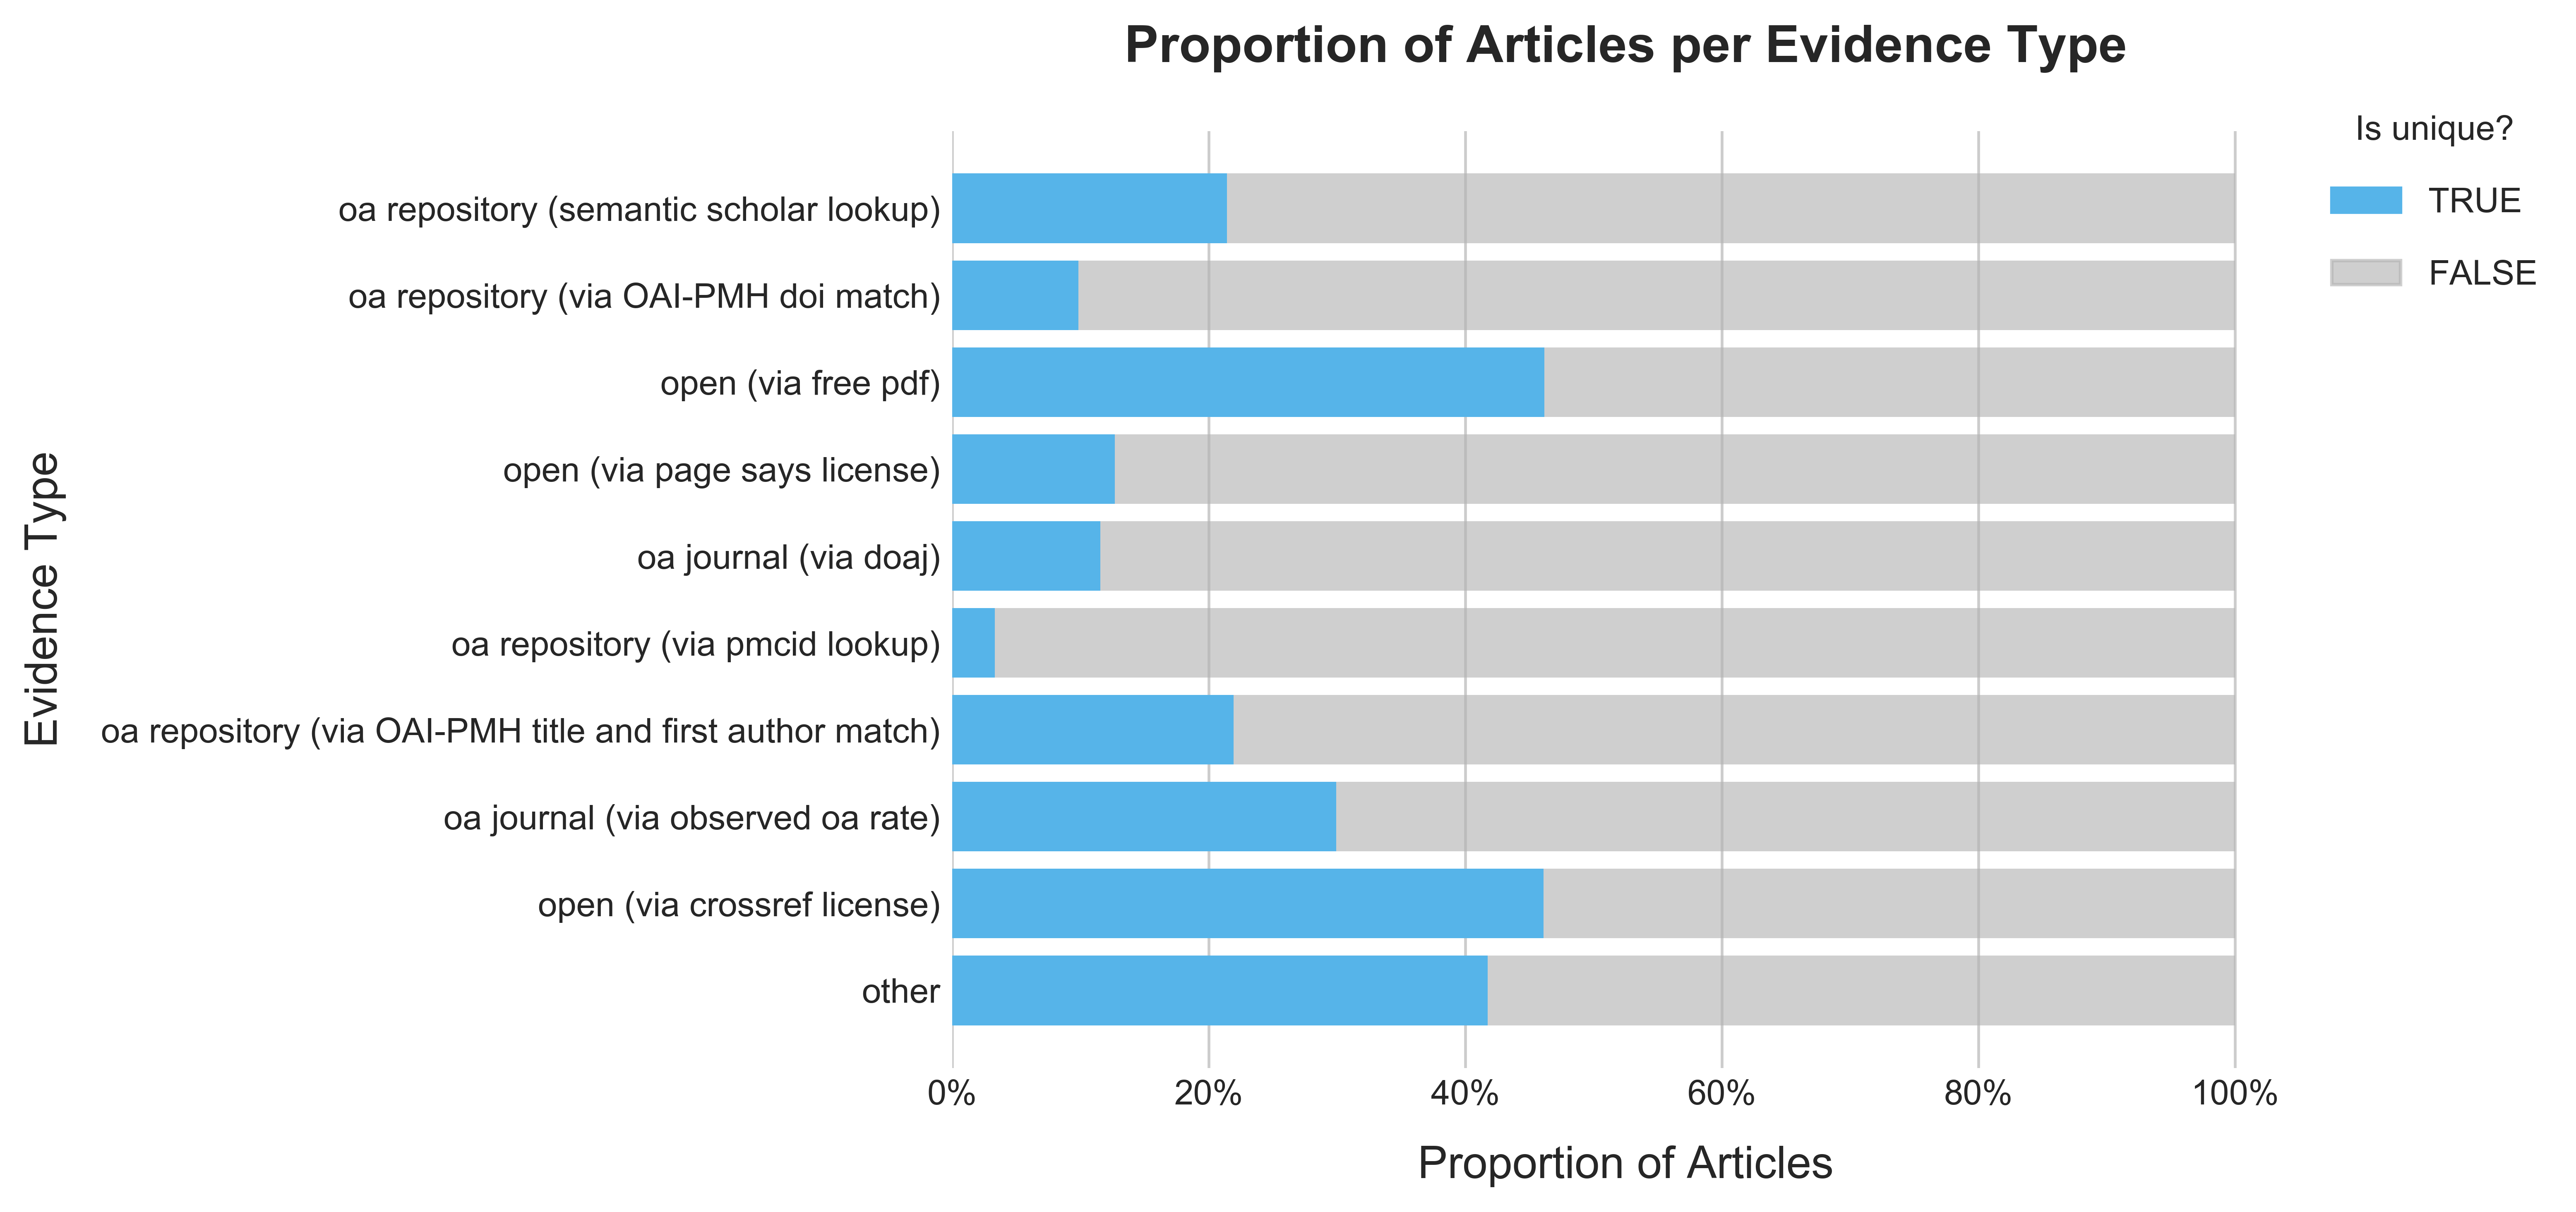

In [31]:
y1 = evidence_single_cat_grouped_df \
                .sort_values(by=['number_of_articles'], ascending=True) \
                .reset_index(drop=True).evidence

x_total = evidence_single_cat_grouped_df.groupby(['evidence']) \
                .number_of_articles.count() \
                .to_frame().reset_index() \
                .sort_values(by=['number_of_articles'], ascending=True) \
                .reset_index(drop=True) \
                .number_of_articles


x_stacked = evidence_single_cat_grouped_df \
                .sort_values(by=['number_of_articles'], ascending=True) \
                .reset_index(drop=True) \
                .prop

fig, ax = plt.subplots(figsize=(7,5))

plt.style.use('seaborn-whitegrid')
#plt.rcParams['figure.figsize'] = [7, 5]
plt.grid(False, which='both', axis='y')
plt.box(False)

ax1 = plt.barh(y1, x_total, color='#b3b3b3a0')
ax2 = plt.barh(y1, x_stacked, color='#56B4E9')

ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))

plt.title('Proportion of Articles per Evidence Type', 
          fontdict={'fontsize': 15, 'fontweight': 600}, pad=20)
plt.xlabel('Proportion of Articles', labelpad=10, 
           fontdict={'fontsize': 13, 'fontweight': 500})

plt.ylabel('Evidence Type', labelpad=10, fontdict={'fontsize': 13, 'fontweight': 500})

is_unique_patch = mpatches.Patch(color='#56B4E9', label='TRUE')
is_not_unique_patch = mpatches.Patch(color='#b3b3b3a0', label='FALSE')
plt.legend(handles=[is_unique_patch, is_not_unique_patch], title='Is unique?', 
           fontsize='medium', bbox_to_anchor=(1.2, 1.05), labelspacing=1.2)

plt.show()